<a href="https://colab.research.google.com/github/AlexeyUdod/aml/blob/master/dll_12_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Задание 
1. Возьмите MNIST, обучите на нем сетку (LeNet)
2. Возьмите какую-нить картинку (из mnist’а)
3. Обучите шум, который при добавлении к оригинальной картинке, заставит ее ошибаться в пользу другого класса

In [1]:
import torch as tr
import torchvision as trv
import matplotlib.pyplot as plt

In [4]:
train = trv.datasets.MNIST('', train = True, transform = trv.transforms.ToTensor(), download=True)
test = trv.datasets.MNIST('', train = False, transform = trv.transforms.ToTensor(), download=True)


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw




Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw




Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw




Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [62]:
batch_size = 1000
data_train = tr.utils.data.DataLoader(train, batch_size = batch_size,shuffle=True)
data_test = tr.utils.data.DataLoader(test, batch_size = test.targets.shape[0])

In [16]:
dev = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')
print(f"work on {(tr.cuda.get_device_name() if dev.type == 'cuda' else 'cpu')}")

work on Tesla V100-SXM2-16GB


In [51]:
class LeNet1(tr.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = tr.nn.Conv2d(1, 6, 5)
        self.conv2 = tr.nn.Conv2d(6, 16, 5)
        self.pool = tr.nn.MaxPool2d(2)
        self.flat = tr.nn.Flatten()
        self.fc1 = tr.nn.Linear(16 * 4 * 4, 120)
        self.fc2 = tr.nn.Linear(120, 84)
        self.fc3 = tr.nn.Linear(84, 10)
    def forward(self, input):
        x = self.pool(self.conv1(input))
        x = self.pool(self.conv2(x))
        x = self.flat(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [65]:
model = LeNet1().to(dev)
optim = tr.optim.Adam(model.parameters())
crit = tr.nn.CrossEntropyLoss()
n_iters = 100

for iter in range(n_iters):
    model.train()
    for X, y in data_train:
        X, y = X.to(dev), y.to(dev)
        optim.zero_grad()
        pred = model(X)
        loss = crit(pred, y)
        loss.backward()
        optim.step()
        train_score = tr.sum(tr.argmax(pred, axis=1) == y).item() / y.shape[0]

    model.eval()
    for X, y in data_test:
        X, y = X.to(dev), y.to(dev)
        pred = model(X)
        test_score = tr.sum(tr.argmax(pred, axis=1) == y).item() / y.shape[0]
        print(f'iter {iter}, loss = {loss}, train score = {train_score}, test score = {test_score}')
    if test_score > 0.98:
        break

iter 0, loss = 0.3972473442554474, train score = 0.869, test score = 0.8801
iter 1, loss = 0.2685721814632416, train score = 0.92, test score = 0.9286
iter 2, loss = 0.1951950490474701, train score = 0.94, test score = 0.9512
iter 3, loss = 0.11497851461172104, train score = 0.965, test score = 0.9645
iter 4, loss = 0.1305743157863617, train score = 0.964, test score = 0.9706
iter 5, loss = 0.10451018810272217, train score = 0.97, test score = 0.9752
iter 6, loss = 0.08759859204292297, train score = 0.975, test score = 0.9765
iter 7, loss = 0.08988972753286362, train score = 0.962, test score = 0.9765
iter 8, loss = 0.059440452605485916, train score = 0.978, test score = 0.978
iter 9, loss = 0.06395965814590454, train score = 0.979, test score = 0.9796
iter 10, loss = 0.05603653937578201, train score = 0.98, test score = 0.9796
iter 11, loss = 0.060512177646160126, train score = 0.979, test score = 0.9799
iter 12, loss = 0.047073084861040115, train score = 0.982, test score = 0.9781
it

KeyboardInterrupt: ignored

In [88]:
model.eval()
noise_size = next(iter(data_test))[0].shape[-1]
noise = tr.nn.Linear(noise_size, noise_size, bias=False).to(dev)
optim = tr.optim.Adam(noise.parameters())
crit = tr.nn.CrossEntropyLoss()
n_iters = 100
target = 5
train_score = 0.1
for iter in range(n_iters):
    noise.train()
    for X, y in data_train:
        X, y = X.to(dev), y.to(dev)
        optim.zero_grad()
        X += noise.weight
        y = y * 0 + target
        pred = model(X)
        # loss = crit(pred, y) + noise.weight.abs().sum() #* 100
        loss = crit(pred, y) * (1 - train_score) + noise.weight.abs().max() * train_score * 10
        loss.backward()
        optim.step()
        train_score = tr.sum(tr.argmax(pred, axis=1) == y).item() / y.shape[0]

    noise.eval()
    for X, y in data_test:
        X, y = X.to(dev), y.to(dev)
        X += noise.weight
        y = y * 0 + target
        pred = model(X)
        test_score = tr.sum(tr.argmax(pred, axis=1) == y).item() / y.shape[0]
        print(f'iter {iter}, loss = {loss}, train score = {train_score}, test score = {test_score}, noise.weight.max {noise.weight.abs().max()}')

iter 0, loss = 11.198670387268066, train score = 0.103, test score = 0.1024, noise.weight.max 0.23129747807979584
iter 1, loss = 5.344184398651123, train score = 0.259, test score = 0.2537, noise.weight.max 0.2765999436378479
iter 2, loss = 2.9030704498291016, train score = 0.521, test score = 0.4899, noise.weight.max 0.3001410961151123
iter 3, loss = 2.5654234886169434, train score = 0.67, test score = 0.6361, noise.weight.max 0.3044135272502899
iter 4, loss = 2.5392305850982666, train score = 0.733, test score = 0.7152, noise.weight.max 0.3035467863082886
iter 5, loss = 2.5124030113220215, train score = 0.763, test score = 0.7588, noise.weight.max 0.29894474148750305
iter 6, loss = 2.541022777557373, train score = 0.817, test score = 0.7909, noise.weight.max 0.29605212807655334
iter 7, loss = 2.53731107711792, train score = 0.814, test score = 0.8101, noise.weight.max 0.292877733707428
iter 8, loss = 2.5340516567230225, train score = 0.844, test score = 0.8261, noise.weight.max 0.290

При добавлении этого шума (с максимальной амплитудой 0.21499983966350555) 
к любому изображению цифры (с максимальной амплитудой 1.214999794960022)
мы с 78.0 % вероятностью получаем на выходе обученной LeNet результат равный 5


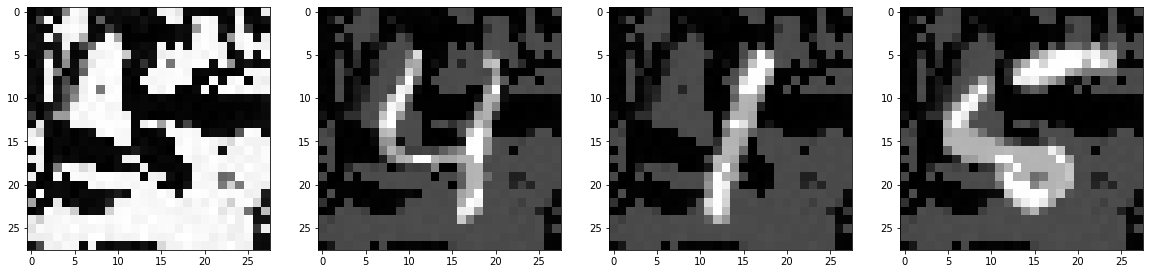

In [125]:
plt.subplot(141)
plt.imshow(noise.weight.cpu().detach(), cmap = 'gray')
plt.subplot(142)
plt.imshow(X[4,0].cpu().detach(), cmap = 'gray')
plt.subplot(143)
plt.imshow(X[5,0].cpu().detach(), cmap = 'gray')
plt.subplot(144)
plt.imshow(X[8,0].cpu().detach(), cmap = 'gray')
plt.gcf().set_size_inches(20, 5)

print(f"""При добавлении этого шума (с максимальной амплитудой {noise.weight.abs().max()}) 
к любому изображению цифры (с максимальной амплитудой {X.abs().max()})
мы с {round(test_score, 3) * 100} % вероятностью получаем на выходе обученной LeNet результат равный {target}""")